In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv
/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import warnings, os, gc, sys, math, json, random, itertools

from scipy import stats
from scipy.stats import ks_2samp

# Pretty settings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")
sns.set_palette("crest")
pd.set_option("display.max_columns", 100)

In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [4]:
train.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
test.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


# Exploratory Data Analysis

# Information

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


In [8]:
train.shape

(18524, 9)

In [9]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [10]:
test.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [11]:
print("Descriptive statistics for numerical columns in train_df:")
display(train.describe())

print("\nDescriptive statistics for categorical columns in train_df:")
display(train.describe(include='object'))

print("\nDescriptive statistics for numerical columns in test_df:")
display(test.describe())

print("\nDescriptive statistics for categorical columns in test_df:")
display(test.describe(include='object'))

Descriptive statistics for numerical columns in train_df:


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000



Descriptive statistics for categorical columns in train_df:


,Stage_fear,Drained_after_socializing,Personality
count,16631,17375,18524
unique,2,2,2
top,No,No,Extrovert
freq,12609,13313,13699



Descriptive statistics for numerical columns in test_df:


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000



Descriptive statistics for categorical columns in test_df:


,Stage_fear,Drained_after_socializing
count,5577,5743
unique,2,2
top,No,No
freq,4236,4437


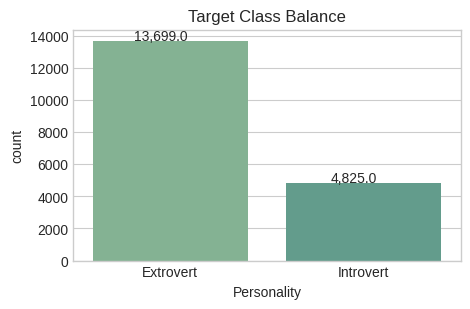

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [12]:
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(data=train, x="Personality", ax=ax)
ax.set_title("Target Class Balance")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x()+.35, p.get_height()+50), ha="center")
plt.show()

print(train["Personality"].value_counts(normalize=True).rename("proportion"))

# Univariate analysis

# Numerical features

**Train data**

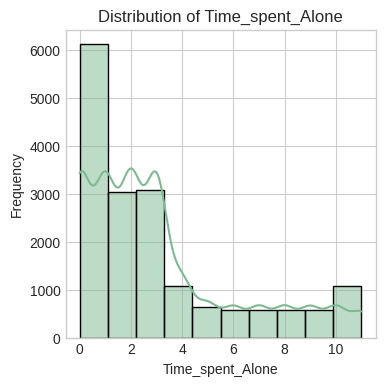

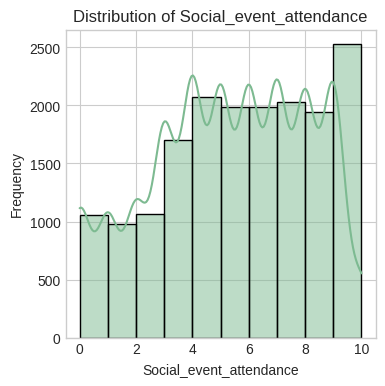

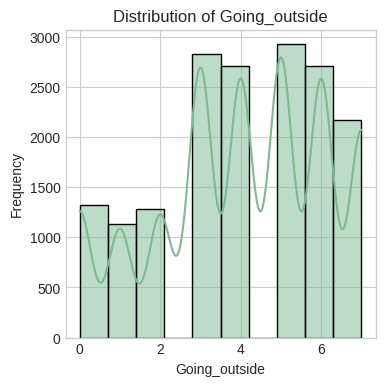

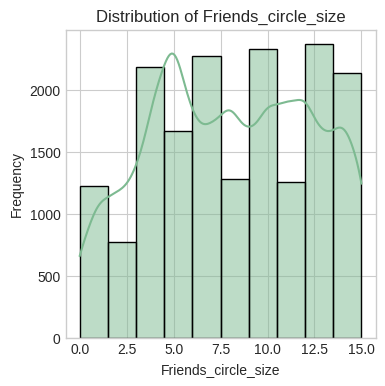

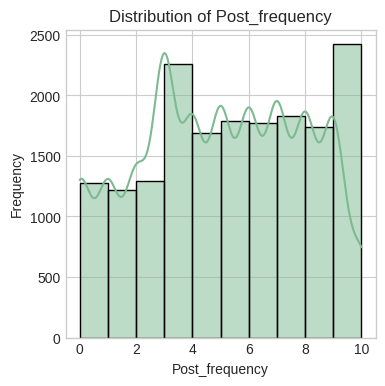

In [13]:
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                   'Friends_circle_size', 'Post_frequency']

for col in numerical_cols:
    plt.figure(figsize=(4,4))
    sns.histplot(train[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [14]:
train[numerical_cols] = train[numerical_cols].apply(pd.to_numeric, errors='coerce')


1.133777036719707
-0.22923760229450502
-0.36722086539805504
-0.051806107204632273
-0.0587064407734749


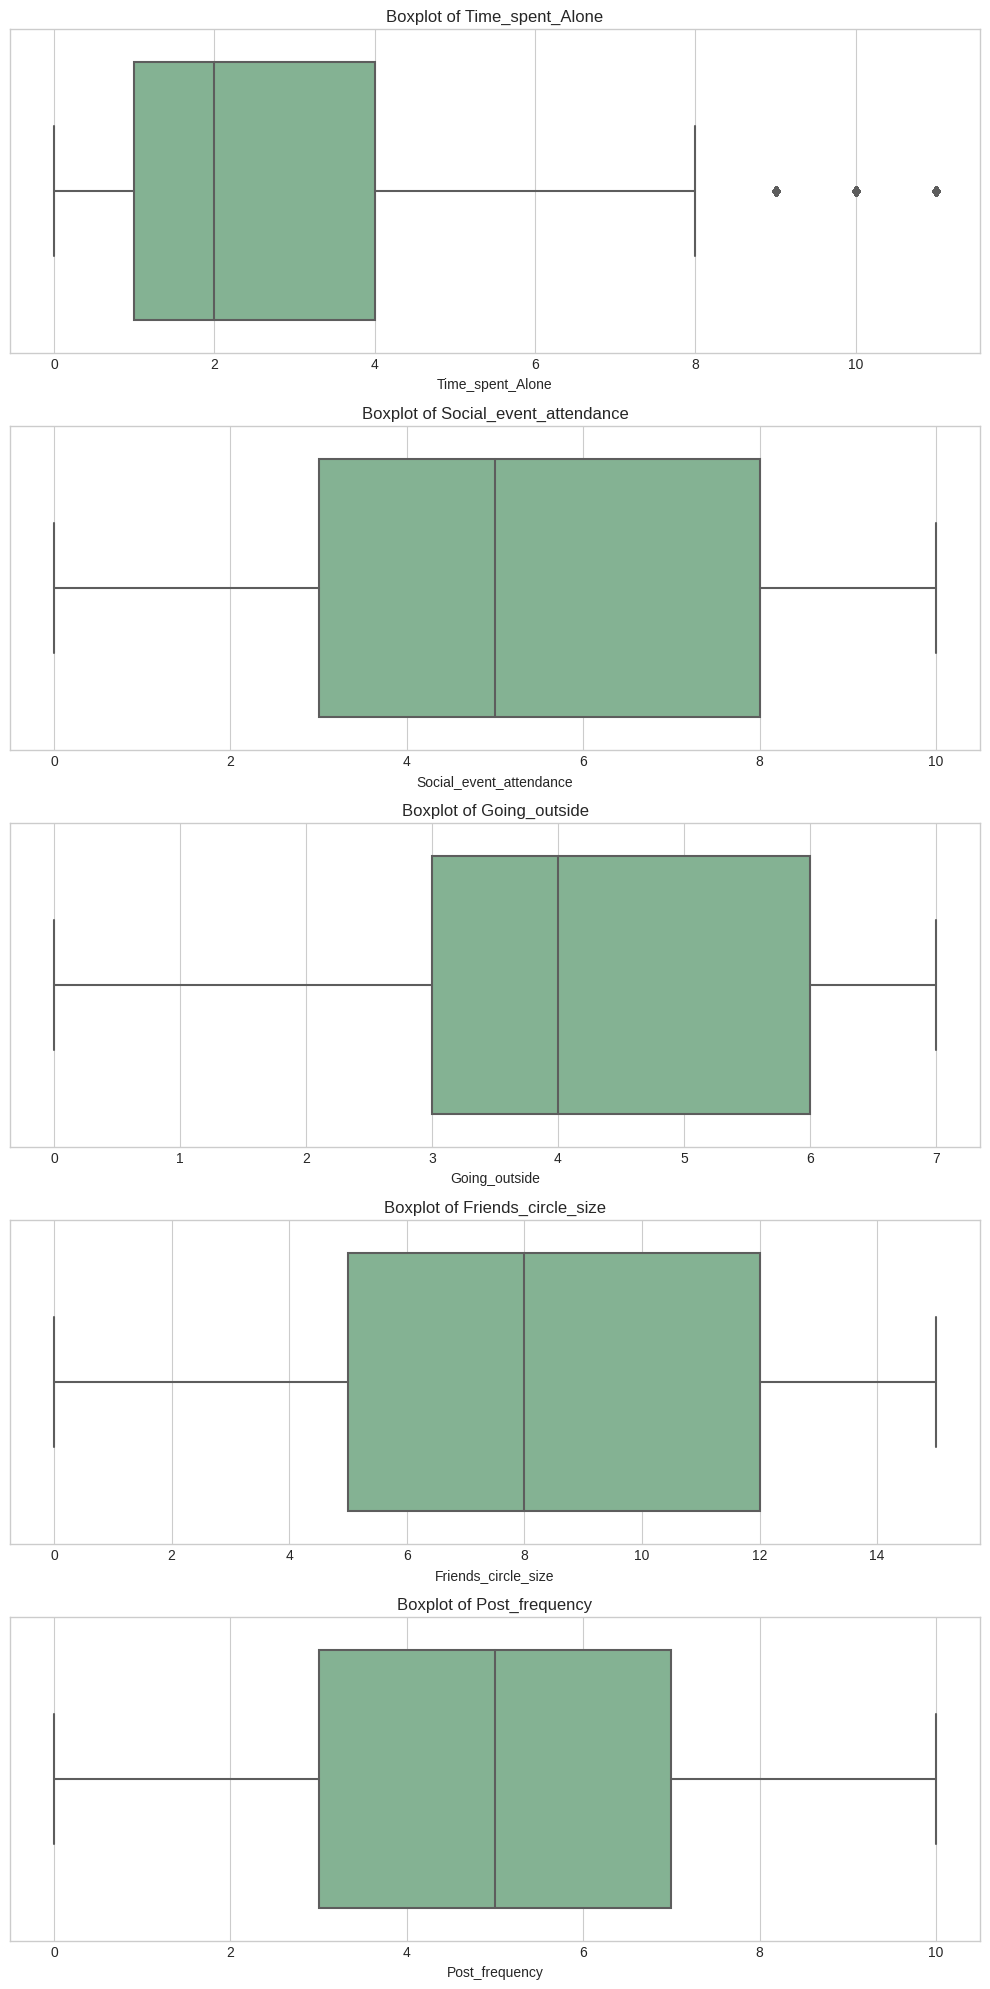

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(10, 20))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    print(train[col].skew())

plt.tight_layout()
plt.show()


**Test data**

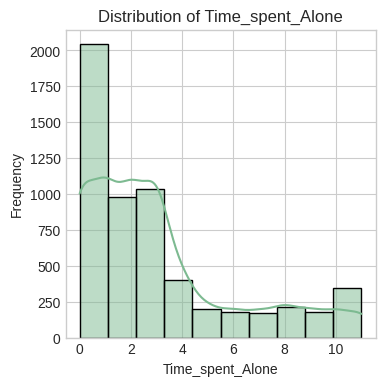

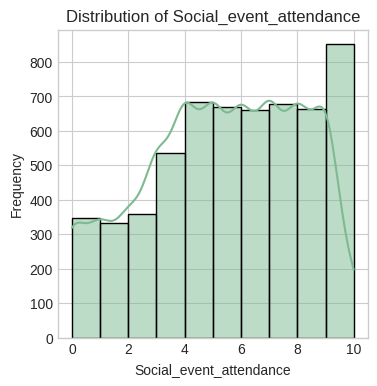

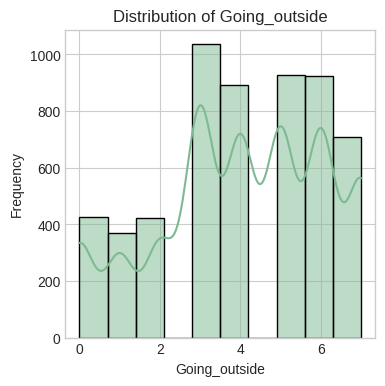

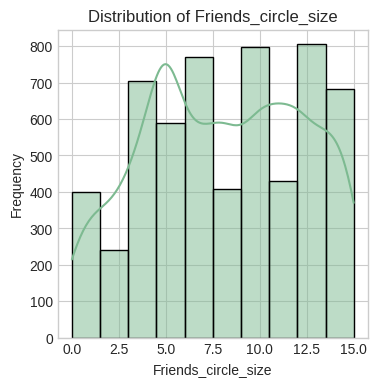

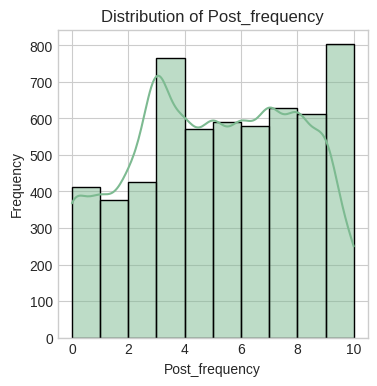

In [16]:
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                   'Friends_circle_size', 'Post_frequency']

for col in numerical_cols:
    plt.figure(figsize=(4,4))
    sns.histplot(test[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

1.1534763251487632
-0.24436140090065894
-0.3453593158723529
-0.06498469447098446
-0.07496136259306817


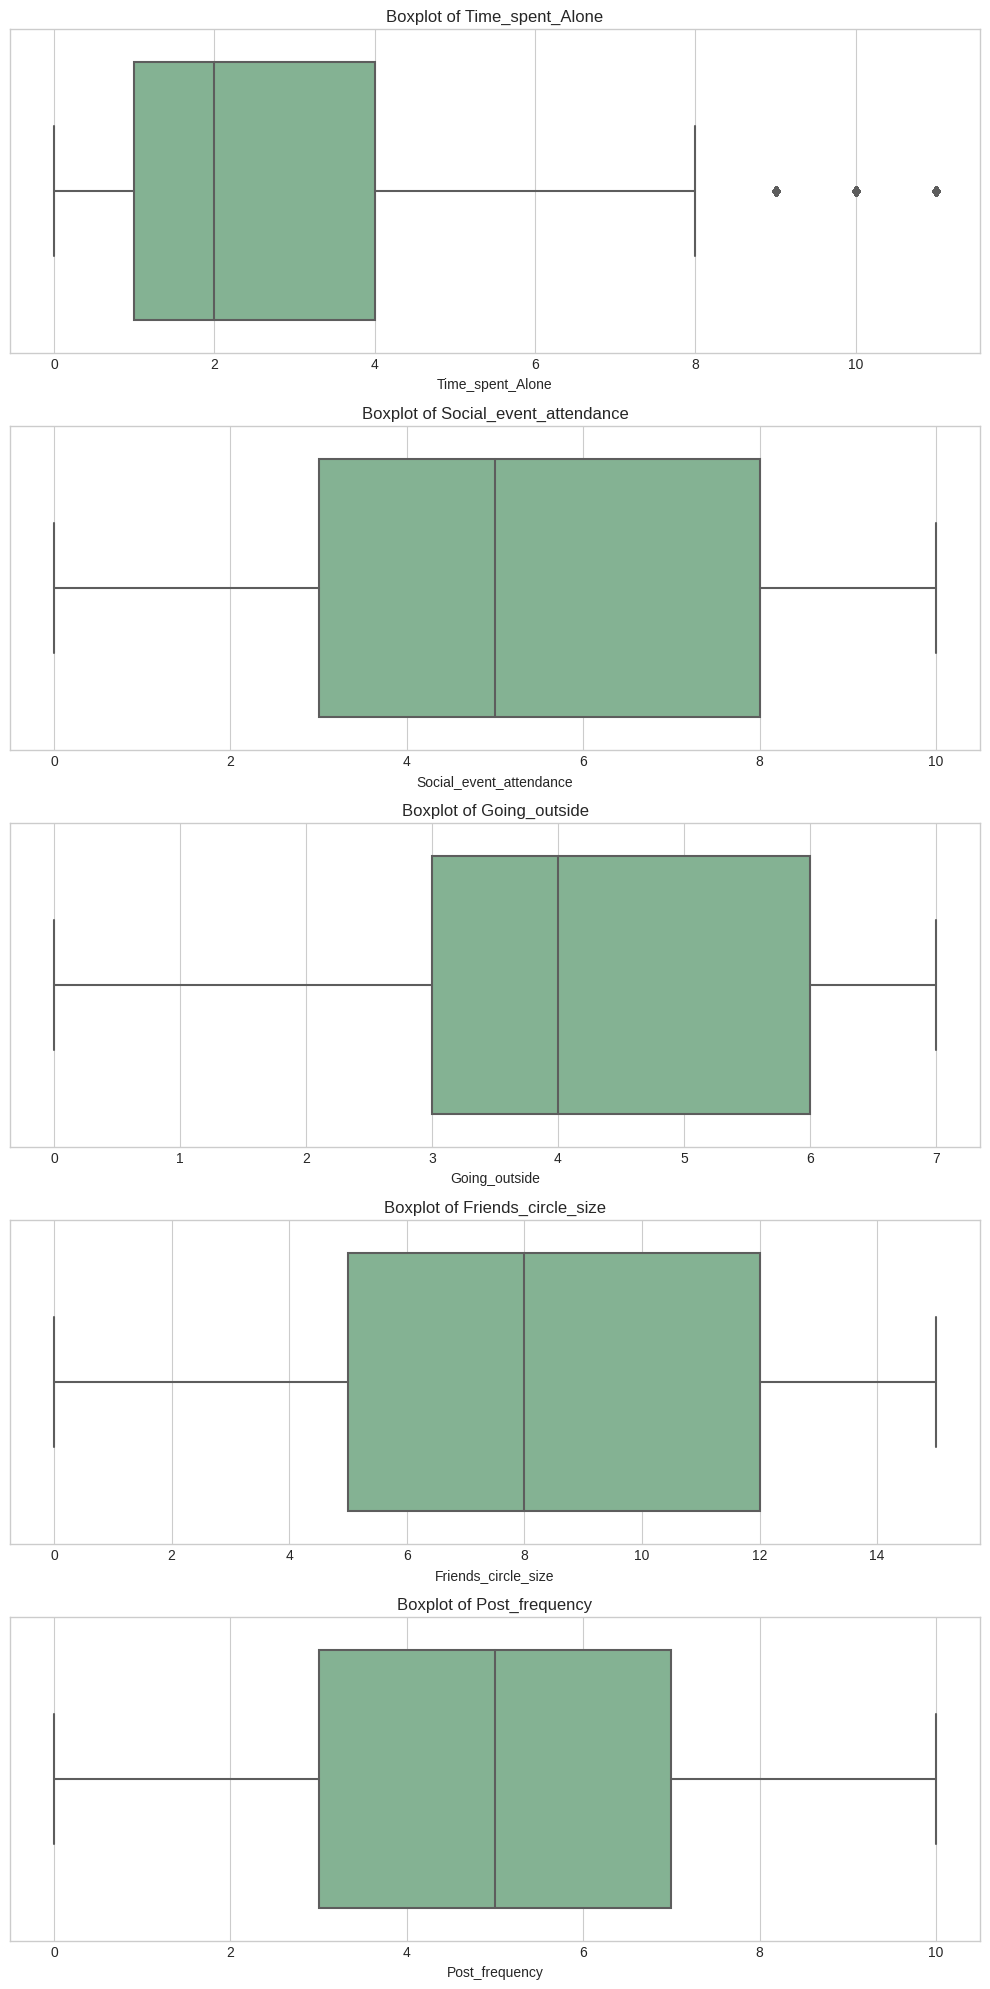

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(10, 20))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=test[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    print(test[col].skew())

plt.tight_layout()
plt.show()


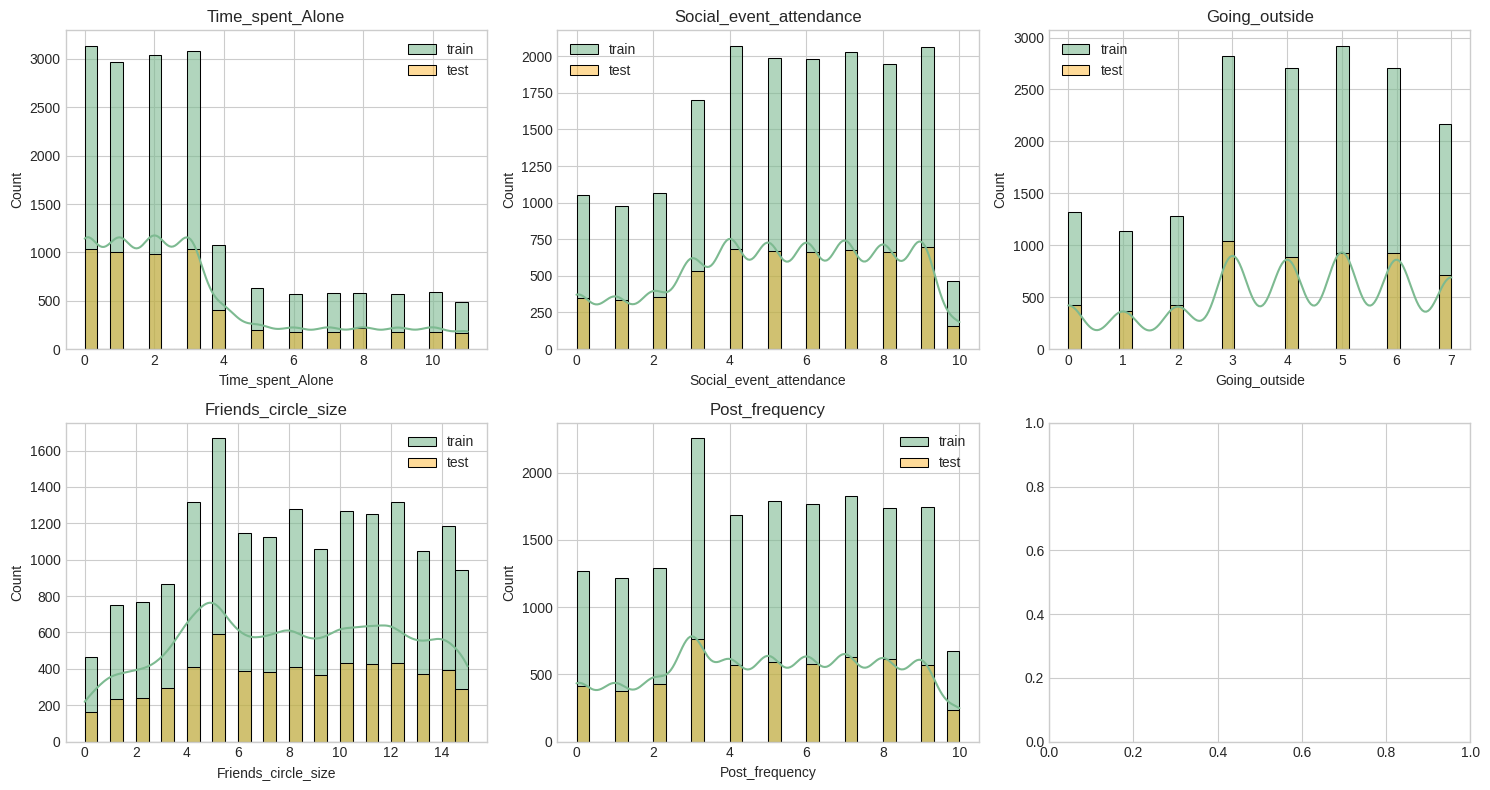

In [18]:
num_cols = train.select_dtypes("number").columns.drop(["id"])  # exclude id
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train[col], kde=True, ax=axes[i], bins=30, alpha=.6, label="train")
    sns.histplot(test[col],  kde=False, ax=axes[i], bins=30, color="orange", alpha=.4, label="test")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/extrovert-vs-introvert-behavior-data


In [20]:
original_0 = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv")
original_1  = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv")
original = pd.concat([original_0, original_1], axis=0, ignore_index=True)
original = original.drop_duplicates().reset_index(drop=True)

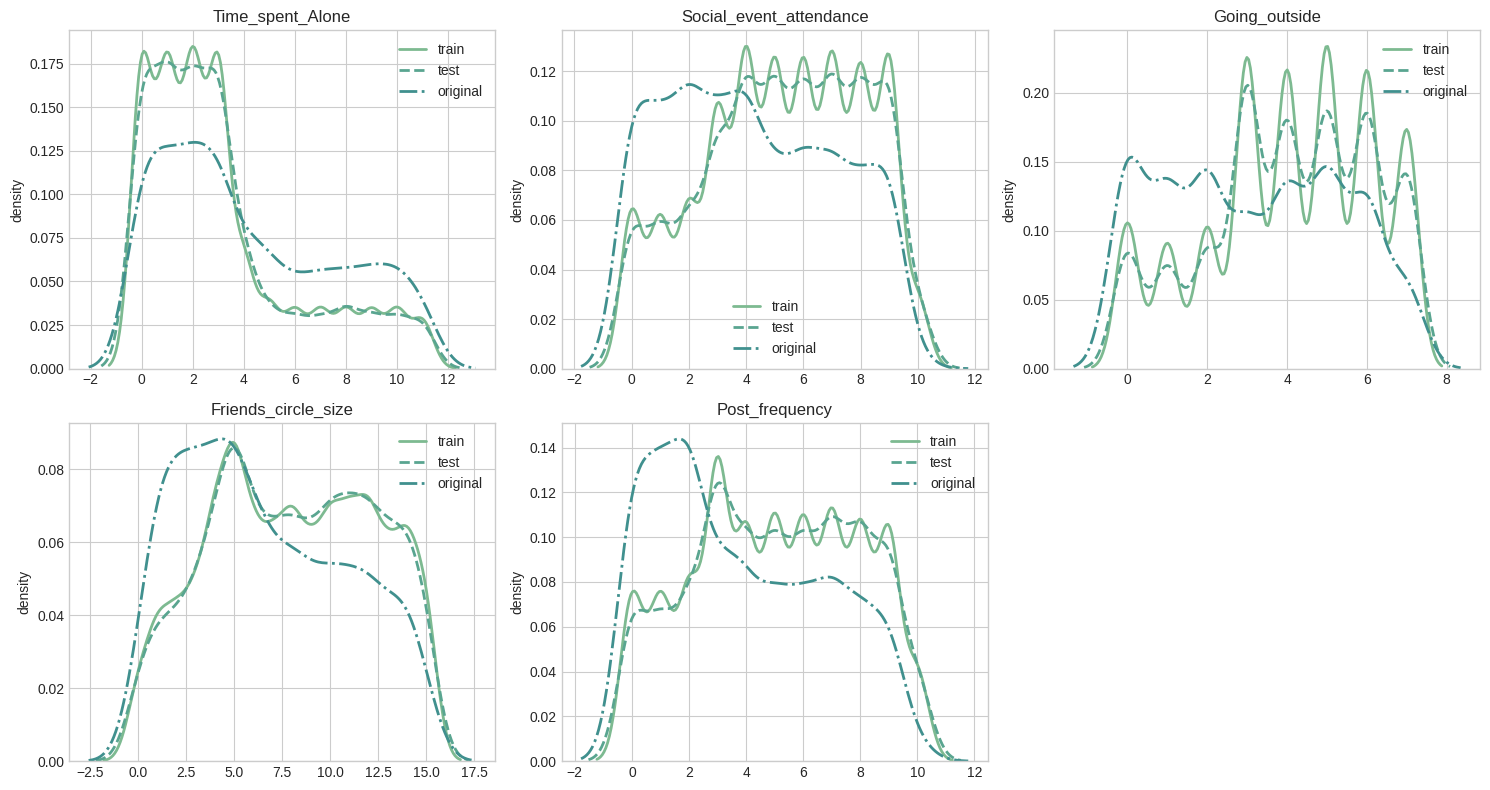

In [21]:
import math
num_cols = train.select_dtypes(np.number).columns.drop("id")        # adjust if 'id' has a different dtype
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.kdeplot(train[col].dropna(), ax=ax, label="train", linewidth=2)
    sns.kdeplot(test[col].dropna(),  ax=ax, label="test" , linewidth=2, linestyle="--")
    sns.kdeplot(original[col].dropna(),  ax=ax, label="original" , linewidth=2, linestyle="-.")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("density")
    ax.legend()

# tidy extra axes (if any)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Categorical Variables

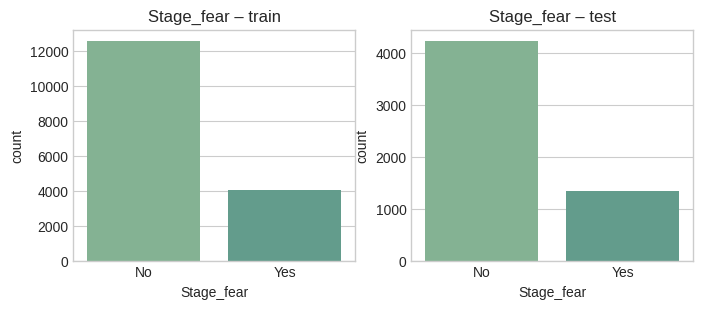

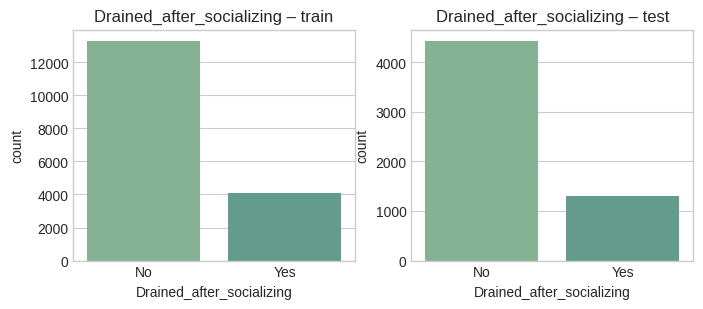

In [22]:
cat_cols = ["Stage_fear", "Drained_after_socializing"]
for col in cat_cols:
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    sns.countplot(x=col, data=train, ax=ax[0])
    ax[0].set_title(f"{col} – train")
    sns.countplot(x=col, data=test,  ax=ax[1])
    ax[1].set_title(f"{col} – test")
    plt.show()


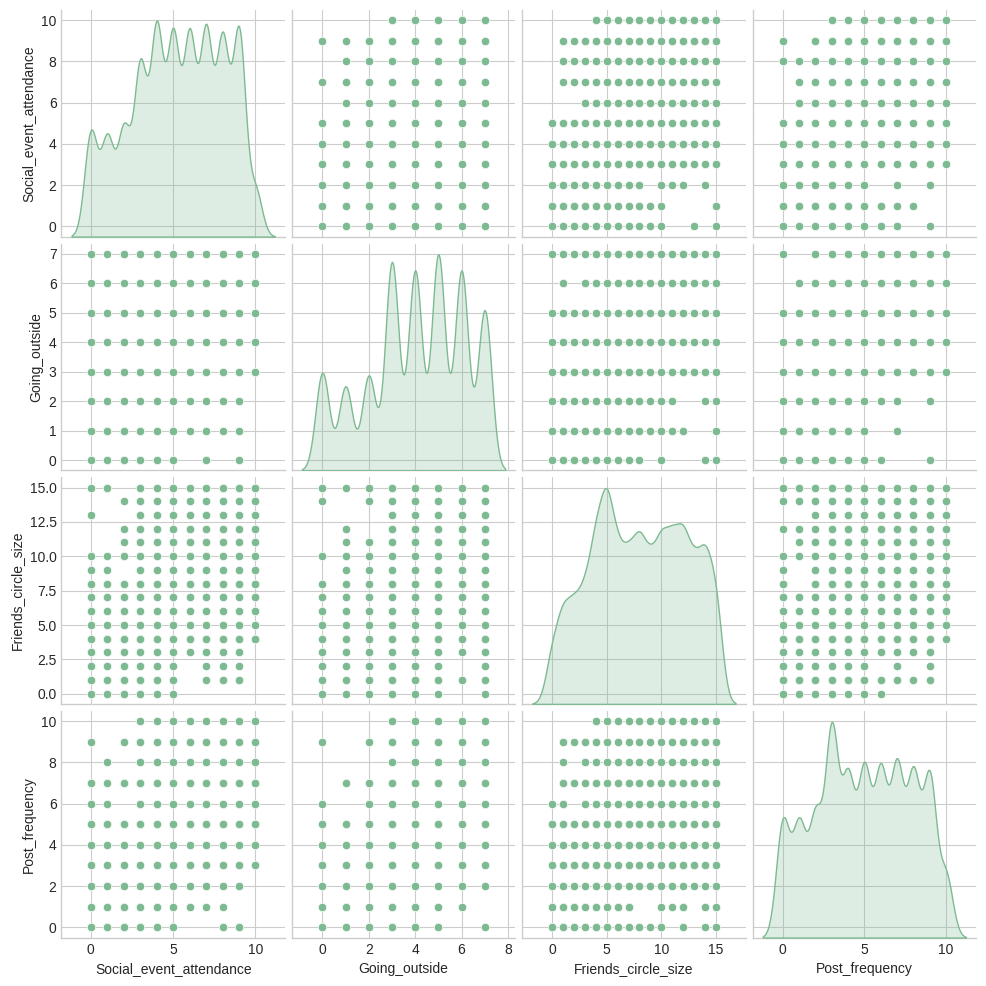

In [23]:
sns.pairplot(train, vars=['Social_event_attendance','Going_outside', 
                   'Friends_circle_size','Post_frequency'],diag_kind='kde')

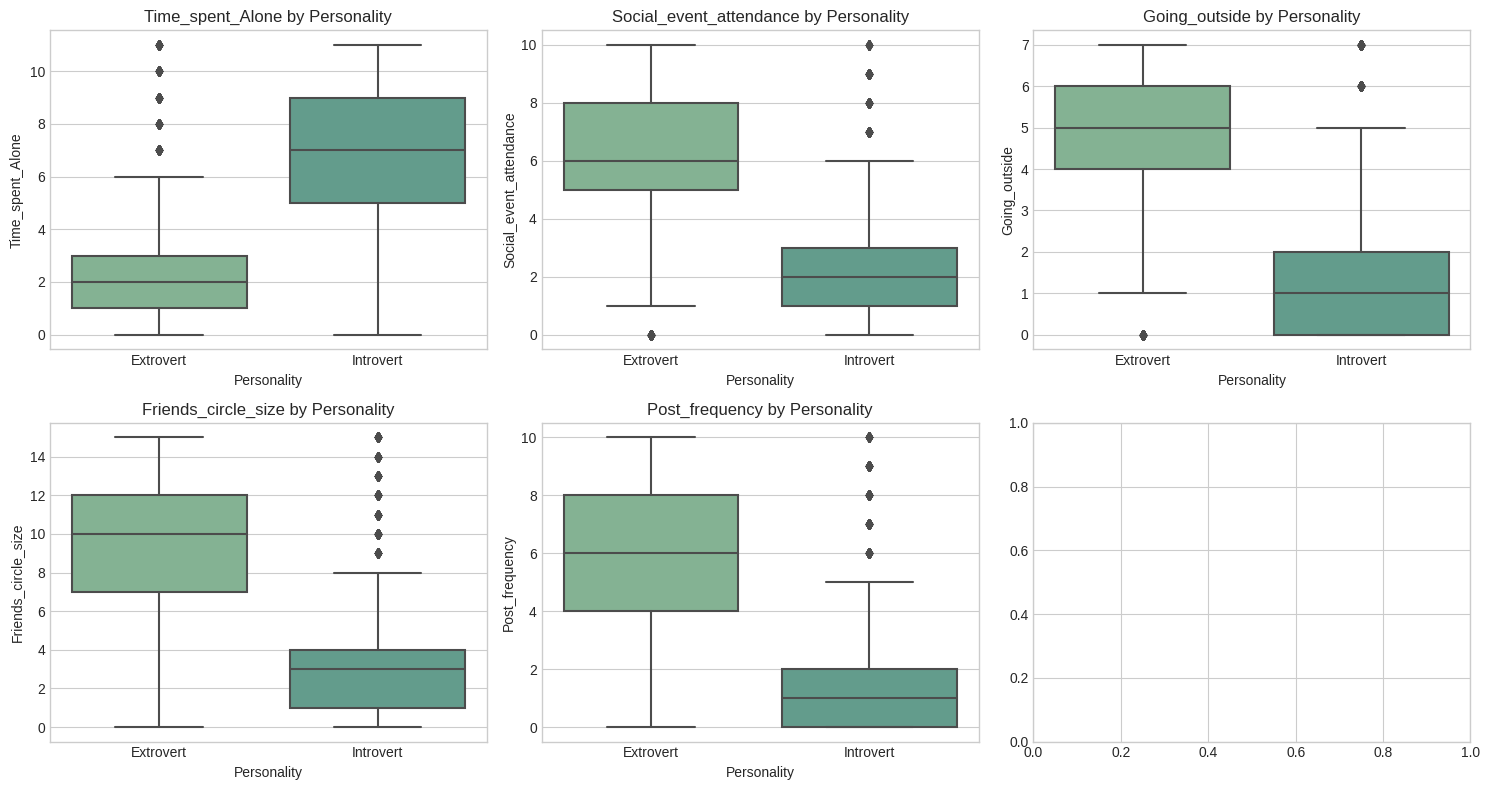

In [24]:
# Numeric vs target
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Personality", y=col, data=train, ax=axes[i])
    axes[i].set_title(f"{col} by Personality")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for col in cat_cols:
    ct = pd.crosstab(train[col], train["Personality"], normalize="index") * 100
    display(ct.style.format("{:.1f}%").set_caption(f"{col} ↔ Personality"))


Personality,Extrovert,Introvert
Stage_fear,,
No,97.7%,2.3%
Yes,5.9%,94.1%


Personality,Extrovert,Introvert
Drained_after_socializing,,
No,97.7%,2.3%
Yes,5.8%,94.2%


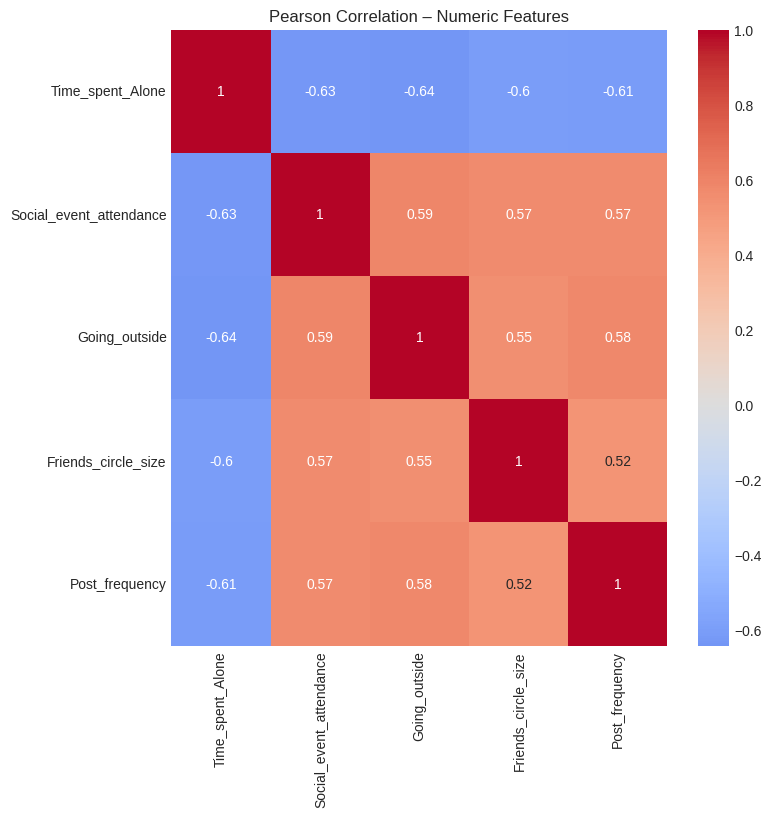

In [26]:
corr = train[num_cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation – Numeric Features")
plt.show()

In [27]:
print(train.columns)

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')


In [28]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [29]:
test.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB



* It is clearly evident that the train and test data have almost same distributions, so that is enough to trian the models to get good results on test data.
* There are missing values for columns except the id and target, same with train and test data sets.
* Time_spent_Alone feature has outliers so can be imputed using median
* other numeric columns- Social_event_attendance, Going_outside, Friends_circle_size, Post_frequency can be imputed using mean.
* The categorical columns- Stage_fear, Drained_after_socializing have missing values- these are of two options, we can impute most frequent one that with mode


The target column is unbalanced, that is may have bias- so need to use stratified cv during training

# Imputation

In [31]:
train['Time_spent_Alone']=train['Time_spent_Alone'].fillna(train['Time_spent_Alone'].median())

In [32]:
test['Time_spent_Alone'] = test['Time_spent_Alone'].fillna(test['Time_spent_Alone'].median())

In [33]:
mean_impute = ['Social_event_attendance','Going_outside', 
                   'Friends_circle_size','Post_frequency']

In [34]:
for col in mean_impute:
    train[col]=train[col].fillna(train[col].mean())

In [35]:
train.isnull().sum()

id                              0
Time_spent_Alone                0
Stage_fear                   1893
Social_event_attendance         0
Going_outside                   0
Drained_after_socializing    1149
Friends_circle_size             0
Post_frequency                  0
Personality                     0
dtype: int64

In [36]:
for col in mean_impute:
    test[col]=train[col].fillna(test[col].mean())

In [37]:
test.isnull().sum()

id                             0
Time_spent_Alone               0
Stage_fear                   598
Social_event_attendance        0
Going_outside                  0
Drained_after_socializing    432
Friends_circle_size            0
Post_frequency                 0
dtype: int64

In [38]:
cat_cols=['Stage_fear','Drained_after_socializing']
train['Stage_fear']= train['Stage_fear'].fillna(train['Stage_fear'].mode()[0])
test['Stage_fear']= test['Stage_fear'].fillna(test['Stage_fear'].mode()[0])

train['Drained_after_socializing']= train['Drained_after_socializing'].fillna(train['Drained_after_socializing'].mode()[0])
test['Drained_after_socializing']= test['Drained_after_socializing'].fillna(test['Drained_after_socializing'].mode()[0])

In [39]:
train.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [40]:
test.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64

# Label Encoding - Categorical Columns

In [41]:
for col in cat_cols:
    train[col] = train[col].map({'No': 0, 'Yes': 1})

In [42]:
for col in cat_cols:
    test[col] = test[col].map({'No': 0, 'Yes': 1})

Target Encoding

In [43]:
train['Personality'] = train['Personality'].map({'Introvert': 0, 'Extrovert': 1})

# Model Building

* weights=[0.9, 0.1]- for imbalanced classes

In [44]:
target_col = 'Personality'  # replace with your actual target column

X = train.drop(columns=[target_col])
y = train[target_col]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [45]:
X.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0,0.0,0,6.0,4.0,0,15.0,5.000000
1,1,1.0,0,7.0,3.0,0,10.0,8.000000
2,2,6.0,1,1.0,0.0,0,3.0,0.000000
3,3,3.0,0,7.0,3.0,0,11.0,5.000000
4,4,1.0,0,4.0,4.0,0,13.0,4.982097


In [46]:
y.head(5)

0    1
1    1
2    0
3    1
4    1
Name: Personality, dtype: int64

# Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("🔍 Logistic Regression")
print(classification_report(y_test, y_pred))



🔍 Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       965
           1       0.97      0.98      0.98      2740

    accuracy                           0.96      3705
   macro avg       0.96      0.95      0.95      3705
weighted avg       0.96      0.96      0.96      3705



# Random forest Classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("🌲 Random Forest")
print(classification_report(y_test, y_pred))


🌲 Random Forest
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       965
           1       0.97      0.98      0.98      2740

    accuracy                           0.96      3705
   macro avg       0.96      0.95      0.95      3705
weighted avg       0.96      0.96      0.96      3705



# XGboost Classifier

In [49]:
import xgboost as xgb

# compute imbalance scale
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = xgb.XGBClassifier(scale_pos_weight=scale, use_label_encoder=False,
                            eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("🚀 XGBoost")
print(classification_report(y_test, y_pred))


🚀 XGBoost
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       965
           1       0.97      0.98      0.97      2740

    accuracy                           0.96      3705
   macro avg       0.95      0.95      0.95      3705
weighted avg       0.96      0.96      0.96      3705



In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weights, verbose=1)

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("🧠 Neural Network")
print(classification_report(y_test, y_pred))


2025-07-18 02:43:15.689780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752806595.930939      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752806595.998259      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/10


2025-07-18 02:43:30.139405: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


464/464 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5972 - loss: 25.1676
Epoch 2/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7628 - loss: 2.6144
Epoch 3/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7789 - loss: 2.8895
Epoch 4/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8098 - loss: 4.0910
Epoch 5/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8882 - loss: 1.2888
Epoch 6/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8422 - loss: 2.1461
Epoch 7/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8823 - loss: 1.8602
Epoch 8/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8442 - loss: 3.1761
Epoch 9/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8781 - loss: 1.8294
Epoch 10/10
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8593 - loss: 1.9444
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
🧠 Neural Network
              precision    recall  f1-score   support

           0       0.93      0.55   

# XGboost prediction

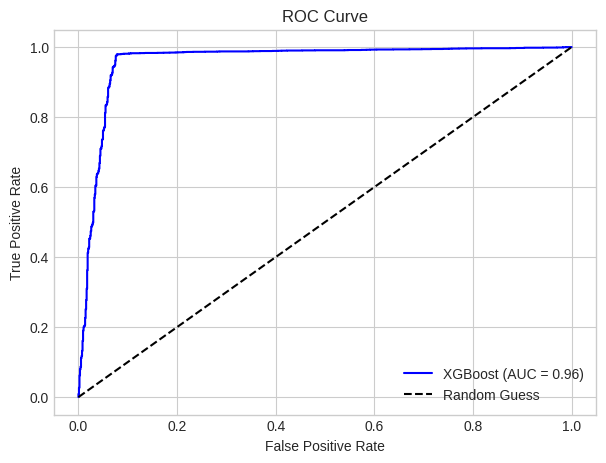

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities (not classes!)
y_probs_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
auc_score = roc_auc_score(y_test, y_probs_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


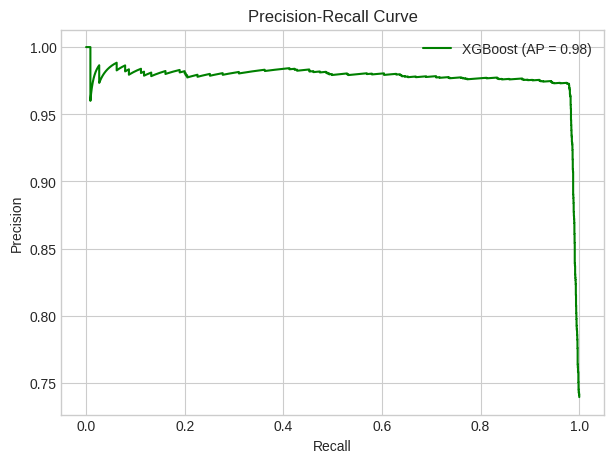

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_xgb)
ap_score = average_precision_score(y_test, y_probs_xgb)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'XGBoost (AP = {ap_score:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
X_test_final = test

In [54]:
# Get probability of class 1
y_probs_xgb = xgb_clf.predict_proba(X_test_final)[:, 1]

# Predict class labels (0 or 1)
y_preds_xgb = xgb_clf.predict(X_test_final)

In [59]:
import pandas as pd
y_preds_xgb = pd.Series(y_preds_xgb).map({'Introvert': 0, 'Extrovert': 1})

In [62]:
submission = test[['id']].copy()
submission['Personality'] = y_preds_xgb  # or y_preds_nn, etc.

# Save to CSV
submission.to_csv("xgboost_test_predictions.csv", index=False)
print("✅ Final submission saved with only id and predicted_class columns.")

✅ Final submission saved with only id and predicted_class columns.
